# COE782- ML - Lista3 - E2

## Dados câncer próstata
Resolução dos itens e) K-fold cross validation

Aluno: Vivian de Carvalho Rodrigues

DRE:125228569 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression, Ridge, Lasso , SGDRegressor, HuberRegressor
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt


#importa os dados do arquivo .csv na mesma pasta deste arquivo
df = pd.read_csv('dados_prostata.csv', sep ='\s+')

In [2]:
df.index = np.arange(97)
df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [3]:
#dados numéricos para padronização (desconsiderou-se as colunas de indices, "Train" e  "lpsa")
#Considera-se somente os dados de entrada 
data = df.iloc[:,:8].to_numpy()

In [4]:
#criando as variáveis em tipo array para que sejam padronizados
lcavol = df['lcavol']                    #volume do cancer (tumor)
lweight = df['lweight']                  #log do peso da prostata
age = df['age']                          #idade
lbph = df['lbph']                        #log de hoperplasia benigna
svi = df['svi']                          #vesicula seminal
lcp = df['lcp']                          #penetração capsular 
gleason = df['gleason']                  #critério gleason
pgg45 = df['pgg45']                      #porcetagem gleason
lpsa = df['lpsa']                        #antígeno específico - target

In [5]:
data.shape

(97, 8)

In [6]:
#a)padronização dos dados
scaler = StandardScaler()
scaler

StandardScaler()

In [7]:
datastd = scaler.fit_transform(data)
datastd.shape

(97, 8)

In [8]:
#dataframe com dados de entrada X padronizados

#inclui os dados y ('lpsa') originais
df_std_aux= pd.DataFrame(datastd, columns= ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']).merge(df['lpsa'],left_index= True, right_index = True)
#incluindo novamente as classes de treino e teste
df_std=df_std_aux.merge(df['train'],left_index= True, right_index = True)


In [9]:
#b)divisão dos dados em treino e teste
#parcela de treino
dfs_train = df_std.loc[df_std['train'] == 'T']


In [10]:
#parcela de teste
dfs_test = df_std.loc[df_std['train'] == 'F']


In [11]:
#organiza dados de entrada e saída do treinamento: 67 registros
X_train = dfs_train.iloc[:,:8].to_numpy()
y_train = dfs_train.iloc[:,8:9].to_numpy().reshape(67)

#organiza dados de entrada e saída de teste: 30 registros
X_test = dfs_test.iloc[:,:8].to_numpy()
y_test = dfs_test.iloc[:,8:9].to_numpy().reshape(30)

In [12]:
y_train.shape

(67,)

In [13]:
#Teste de utilização do cross validation score com 1 fator de regularização
#Modelo Ridge

freg = 0.25                 #fator de regularização - lambda do Bishop
ridge = Ridge(alpha=freg)   #modelo
folds = 10                  #quantidade de folds

#definição do da quantidade de folds k-fold cross validation
cross = KFold(n_splits=folds, shuffle=True )   #condições de teste (definição do k-fold)
r2_test = cross_val_score(ridge, X_train, y_train, scoring='r2', cv=cross)
rms_test = cross_val_score(ridge, X_train, y_train, scoring='neg_mean_squared_error', cv=cross)
r2_test, np.mean(r2_test), rms_test, np.mean(rms_test)

(array([ 0.83409707,  0.7216415 , -0.57919051,  0.48784808,  0.41866923,
         0.88405374,  0.52948704, -0.37958371, -0.15024076, -1.62154194]),
 0.11452397545614783,
 array([-1.33915542, -0.34840011, -0.87177605, -0.40506878, -0.71091192,
        -0.7351085 , -0.18490006, -0.6565792 , -0.143552  , -0.12737255]),
 -0.5522824586879871)

In [14]:
#Teste supondo que o melhor lambda seja 0.25
min(-rms_test)

0.127372545988623

In [15]:
#score mínimo + 1 desvio padrão do score mínimo
#Neste caso é o a própria média deste lambda (0.25)
rms_min = -np.mean(rms_test)    #score mínimo
rms_std = np.std(rms_test)     #desvio padrão do score mímimo

rms_min, rms_std

(0.5522824586879871, 0.36558588914759077)

In [16]:
#limite de seleção do lambda (Regra o 1 desvio padrão)
limite = rms_min + rms_std
limite

0.9178683478355778

## Escolha do fator de regularização (lambda)

In [17]:
#https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/
#e) K- fold cross validations Verificação do melhor lambda [0,0.5]

#define-se a quantidade de modelos (quantidade de lambadas)
freg_list = np.arange(0.,0.5,0.005)
freg_list.shape

(100,)

### Modelo Ridge

In [18]:
#lista de modelos a serem avaliados
#Modelo Ridge 
def get_models():
    models = list()
    for i in range(len(freg_list)): 
        models.append(Ridge(alpha=freg_list[i]))
    return models

# avalia o modelo dada a condição de teste (cross validation -cv)
# #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
def evaluate_model(X, y, cv, model):
    r2 = cross_val_score(model, X, y, scoring='r2', cv=cv)
    rms = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    return r2, rms

In [19]:
#modelos com diferentes fatores de regularização
models = get_models()
cval = KFold(n_splits=folds, shuffle=True)   #condições de teste (definição do k-fold)

det=[]
RMS=[]
# avaliação de cada modelos
for model in models:
    determ, r_ms = evaluate_model(X_train, y_train, cval, model)
    det.append(determ)                                            #salva matriz com os coeficientes de determinação r2
    RMS.append(r_ms)                                              #salva matriz com os erros médios quadráticos (rms)
    print('Modelo = ', model)
    print('Média r2:', np.mean(determ), '/ Desvio r2:', np.std(determ))
    print('Média rms:', -np.mean(r_ms), '/  Desvio rms:', np.std(r_ms))
det = np.array(det)                                                          
RMS = np.array(RMS)

Modelo =  Ridge(alpha=0.0)
Média r2: 0.2973122799066722 / Desvio r2: 0.5766345120880528
Média rms: 0.595745250821841 /  Desvio rms: 0.29850505035893865
Modelo =  Ridge(alpha=0.005)
Média r2: 0.3920688901266321 / Desvio r2: 0.4286063537059632
Média rms: 0.566111174602268 /  Desvio rms: 0.29304340207879204
Modelo =  Ridge(alpha=0.01)
Média r2: 0.3843380981875989 / Desvio r2: 0.41441762643838204
Média rms: 0.5946810895110665 /  Desvio rms: 0.3734583179357011
Modelo =  Ridge(alpha=0.015)
Média r2: 0.5407763095187349 / Desvio r2: 0.19087528978990057
Média rms: 0.6291019143436258 /  Desvio rms: 0.37590962879391704
Modelo =  Ridge(alpha=0.02)
Média r2: 0.437640597584611 / Desvio r2: 0.35398111044144276
Média rms: 0.6040633367461133 /  Desvio rms: 0.22702298102860613
Modelo =  Ridge(alpha=0.025)
Média r2: 0.3269033863947029 / Desvio r2: 0.8408358560821834
Média rms: 0.5810387659657059 /  Desvio rms: 0.25764690282104835
Modelo =  Ridge(alpha=0.03)
Média r2: 0.44849774645620977 / Desvio r2: 0.38

Modelo =  Ridge(alpha=0.3)
Média r2: 0.47823640909676685 / Desvio r2: 0.3739412395278959
Média rms: 0.6082248879729123 /  Desvio rms: 0.27062164925788684
Modelo =  Ridge(alpha=0.305)
Média r2: 0.43845435866792515 / Desvio r2: 0.47146239549591124
Média rms: 0.5861286109250483 /  Desvio rms: 0.26661017321066305
Modelo =  Ridge(alpha=0.31)
Média r2: 0.18484341399152523 / Desvio r2: 0.8813024257404815
Média rms: 0.555748924334998 /  Desvio rms: 0.2582874381652917
Modelo =  Ridge(alpha=0.315)
Média r2: 0.2656895014085602 / Desvio r2: 0.6966878400909967
Média rms: 0.5863623762052946 /  Desvio rms: 0.33320186821194636
Modelo =  Ridge(alpha=0.32)
Média r2: 0.1143069553435468 / Desvio r2: 1.0376637122040488
Média rms: 0.6361044457273766 /  Desvio rms: 0.4586600006170234
Modelo =  Ridge(alpha=0.325)
Média r2: 0.4352461624580413 / Desvio r2: 0.4533638310348296
Média rms: 0.5751301766589985 /  Desvio rms: 0.34712169017635014
Modelo =  Ridge(alpha=0.33)
Média r2: 0.46031046738456494 / Desvio r2: 0.

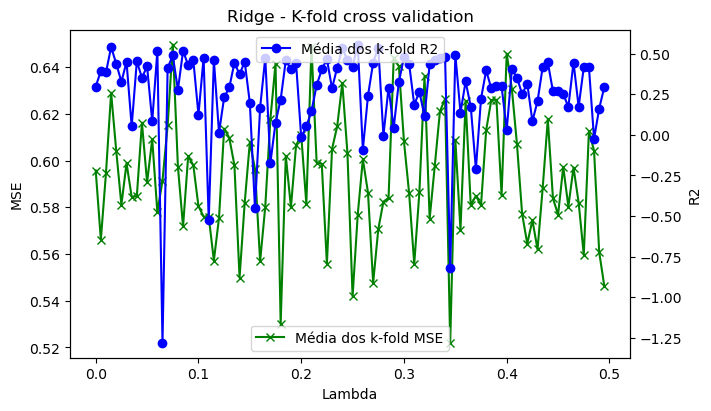

In [20]:
#Ridge Gráfico com resumo dos resultados
fig, axs = plt.subplots(1, 1, figsize=(7, 4), layout='constrained')

axs.plot(freg_list, np.mean(RMS*(-1), axis = 1), color="g", marker = 'x', label = "Média dos k-fold MSE")
#plt.errorbar(freg_list, np.mean(RMS*(-1), axis = 1), yerr = np.std(RMS, axis = 1), ecolor='r',ls='',capsize = 7)
#plt.xscale('log')
axs.set_xlabel("Lambda")  
axs.set_ylabel("MSE")  

#inclui segundo eixo y
axs1 = axs.twinx()

axs1.plot(freg_list, np.mean(det, axis = 1), color="b", marker = 'o', label = "Média dos k-fold R2")
#plt.errorbar(freg_list, np.mean(det, axis = 1), yerr = np.std(det, axis = 1), ecolor='r',ls='',capsize = 7)
axs1.set_ylabel("R2")               

axs.legend(loc = 'lower center')
axs1.legend(loc = 'upper center')
axs.set_title("Ridge - K-fold cross validation")
plt.show()

In [21]:
#Seleção do menor erro médio quadrático (RMS)

lambdas = len(freg_list)                     #quantidade de lambdas
rmsridge_mean = -np.mean(RMS, axis = 1)       #lista das médias dos erros quadraticos médio de cada lambda
rmsridge_std = np.std(RMS, axis = 1)          #lista dos desvios padrão dos erros quadraticos médio de cada lambda


rmsridge = []
for i in range(lambdas):
    rmsridge.append([freg_list[i], rmsridge_mean[i], rmsridge_std[i]]) 
rmsridge = np.array(rmsridge)


In [22]:
#dataframe com as médias dos erros médios quadráticos associados aos lambdass
df_rmsridge= pd.DataFrame(rmsridge, columns= ['lambda', 'rms_average', 'rms_std'])
df_rmsridge = df_rmsridge.reset_index()


In [23]:
#localiza lambda e desvio padrão associado ao mínimo erro quadrático médio (média dos folds)
lambda_min = df_rmsridge.loc[df_rmsridge['rms_average'] == min(rmsridge_mean)]
lambda_min = lambda_min.to_numpy()
lambda_min, int(lambda_min[0,0])

(array([[69.        ,  0.345     ,  0.52193826,  0.26274394]]), 69)

In [24]:
#Verifica o menor fold associado ao lambda min (média dos folds)
min(RMS[int(lambda_min[0,0])]*(-1)) , lambda_min[0,2]

(0.11562883925458171, 0.5219382647605915)

In [25]:
#score mínimo + 1 desvio padrão do score mínimo
rmsridge_min = min(RMS[int(lambda_min[0,0])]*(-1))                        #score mínimo
rmsridge_std = lambda_min [0,3]                                           #desvio padrão do score mímimo

#limite de seleção do lambda (Regra o 1 desvio padrão)
limite = (rmsridge_min + rmsridge_std)
limite

0.3783727780913986

In [26]:
#Seleção do que resulta em um modelo mais simples score_min + limite/2
lambda_selected = df_rmsridge.loc[df_rmsridge['rms_average'] <= lambda_min[0,2] + 0.5*limite]


In [27]:
#No modelo ridge nota-se que, na média dos folds, não há uma evolução do erro quadrático médio. 
#Portanto, será considerado o lambda médio dos 5 lambdas na vizinhaça do lambda que apresentou o menor erro quadrático médio. 
#Lambda com menor RMS centrado na vizinhança
lambda_selection = df_rmsridge.loc[df_rmsridge['rms_average'] == min(rmsridge_mean)]    #localiza lambda e desvio padrão associado ao mínimo erro quadrático médio (média dos folds)
lambda_aux = df_rmsridge.loc[df_rmsridge['index'] < int(lambda_selection['index'])+3]   #vizinhança superior
lambda_aux = lambda_aux.loc[lambda_aux['index'] > int(lambda_selection['index'])-3]     #vizinahnça inferior
lambda_selected = lambda_aux.to_numpy()                                                 #converte para array
lambda_ridge = np.mean(lambda_selected[:,1])                                            #média dos 5 vizinhos
lambda_ridge

0.34500000000000003

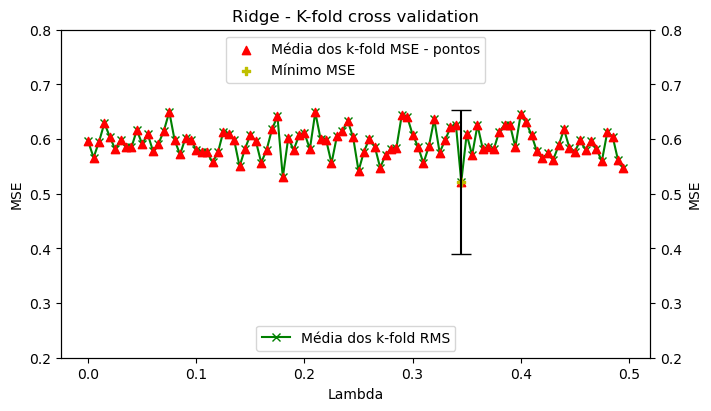

In [28]:
#Ridge Gráfico com resumo dos resultados
fig, axs = plt.subplots(1, 1, figsize=(7, 4), layout='constrained')

axs.plot(freg_list, np.mean(RMS*(-1), axis = 1), color="g", marker = 'x', label = "Média dos k-fold RMS")
#plt.errorbar(freg_list, np.mean(RMS*(-1), axis = 1), yerr = np.std(RMS, axis = 1), ecolor='r',ls='',capsize = 7)
#plt.xscale('log')
axs.set_ylim(0.2, 0.8)
axs.set_xlabel("Lambda")  
axs.set_ylabel("MSE")  

#inclui segundo eixo y
axs1 = axs.twinx()

axs1.scatter(freg_list, np.mean(RMS*(-1), axis = 1), color="r", marker = '^', label = "Média dos k-fold MSE - pontos")
axs1.scatter(lambda_min [0,1], lambda_min [0,2], color="y", marker = 'P', label = "Mínimo MSE")
plt.errorbar(lambda_min [0,1], lambda_min [0,2], yerr = lambda_min [0,3]/2, ecolor='black',ls='',capsize = 7)
axs1.set_ylim(0.2, 0.8)
axs1.set_ylabel("MSE")               

axs.legend(loc = 'lower center')
axs1.legend(loc = 'upper center')
axs.set_title("Ridge - K-fold cross validation")
plt.show()

### Lasso

In [29]:
#lista de modelos a serem avaliados
#Modelo Lasso 
def get_models():
    models = list()
    for i in range(len(freg_list)): 
        models.append(Lasso(alpha=freg_list[i], max_iter = 1000))
    return models

# avalia o modelo dada a condição de teste (cross validation -cv)
# #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
def evaluate_model(X, y, cv, model):
    r2 = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
    rms = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    return r2, rms

In [30]:
models = get_models()

detl=[]
RMSl=[]
# avaliação de cada modelos
for model in models:
    determ, r_ms = evaluate_model(X_train, y_train, cval, model)
    detl.append(determ)                                            #salva matriz com os coeficientes de determinação r2
    RMSl.append(r_ms)                                              #salva matriz com os erros médios quadráticos (rms)
    print('Modelo = ', model)
    print('Média r2:', np.mean(determ), '/ Desvio r2:', np.std(determ))
    print('Média rms:', -np.mean(r_ms), '/  Desvio rms:', np.std(r_ms))
detl = np.array(detl)                                                          #
RMSl = np.array(RMSl)

Modelo =  Lasso(alpha=0.0)
Média r2: 0.3256949818667138 / Desvio r2: 0.3986890061356203
Média rms: 0.5903151787607234 /  Desvio rms: 0.27326038803680086
Modelo =  Lasso(alpha=0.005)
Média r2: 0.2238995570338984 / Desvio r2: 0.5449714993951027
Média rms: 0.6161644536977507 /  Desvio rms: 0.3362187779746555
Modelo =  Lasso(alpha=0.01)
Média r2: 0.42171725203196575 / Desvio r2: 0.2882154966312569
Média rms: 0.5963157120438966 /  Desvio rms: 0.37169908905600146
Modelo =  Lasso(alpha=0.015)
Média r2: 0.5170393697085071 / Desvio r2: 0.2617272660013264
Média rms: 0.5613524978743172 /  Desvio rms: 0.3487002826846296
Modelo =  Lasso(alpha=0.02)
Média r2: 0.5122806720055401 / Desvio r2: 0.25766467870053084
Média rms: 0.5676147739958554 /  Desvio rms: 0.28662574741146024
Modelo =  Lasso(alpha=0.025)
Média r2: 0.25958225766217063 / Desvio r2: 0.9782075051701448
Média rms: 0.5824695683022117 /  Desvio rms: 0.1361449558470821
Modelo =  Lasso(alpha=0.03)
Média r2: 0.42405210644498714 / Desvio r2: 0.2

Modelo =  Lasso(alpha=0.305)
Média r2: 0.2017600439599328 / Desvio r2: 0.4900078755006188
Média rms: 0.8404866060513226 /  Desvio rms: 0.5978032800105842
Modelo =  Lasso(alpha=0.31)
Média r2: -0.07838564387478897 / Desvio r2: 1.1290886197490206
Média rms: 0.7535996606376281 /  Desvio rms: 0.33946853510950137
Modelo =  Lasso(alpha=0.315)
Média r2: 0.354273666091801 / Desvio r2: 0.29296225062845055
Média rms: 0.757433480246951 /  Desvio rms: 0.4703583568958805
Modelo =  Lasso(alpha=0.32)
Média r2: 0.4056552275310084 / Desvio r2: 0.1052879177993364
Média rms: 0.7404699427345505 /  Desvio rms: 0.29952655752897756
Modelo =  Lasso(alpha=0.325)
Média r2: 0.3781735540473444 / Desvio r2: 0.11298163530035316
Média rms: 0.7804921023983487 /  Desvio rms: 0.45979650301529235
Modelo =  Lasso(alpha=0.33)
Média r2: 0.09937472146924313 / Desvio r2: 0.4913046225770774
Média rms: 0.7401350847022685 /  Desvio rms: 0.3590207733052623
Modelo =  Lasso(alpha=0.335)
Média r2: 0.4117758041805805 / Desvio r2: 0.

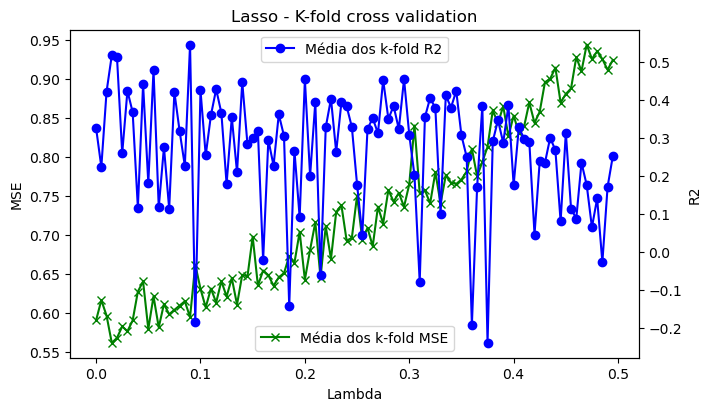

In [31]:
#Ridge Gráfico com resumo dos resultados
fig, axs = plt.subplots(1, 1, figsize=(7, 4), layout='constrained')

axs.plot(freg_list, np.mean(RMSl*(-1), axis = 1), color="g", marker = 'x', label = "Média dos k-fold MSE")
#plt.errorbar(freg_list, np.mean(RMS*(-1), axis = 1), yerr = np.std(RMS, axis = 1)/1000, ecolor='r',ls='',capsize = 7)
axs.set_xlabel("Lambda")  
axs.set_ylabel("MSE")  

#inclui segundo eixo y
axs1 = axs.twinx()

axs1.plot(freg_list, np.mean(detl, axis = 1), color="b", marker = 'o', label = "Média dos k-fold R2")
#plt.errorbar(freg_list, np.mean(det, axis = 1), yerr = np.std(det, axis = 1)/1000, ecolor='r',ls='',capsize = 7)
axs1.set_ylabel("R2")               

axs.legend(loc = 'lower center')
axs1.legend(loc = 'upper center')
axs.set_title("Lasso - K-fold cross validation")
plt.show()

In [32]:
#Seleção do menor erro médio quadrático (RMS)

#lambdas = len(freg_list)                     #quantidade de lambdas
rmslasso_mean = -np.mean(RMSl, axis = 1)       #lista das médias dos erros quadraticos médio de cada lambda
rmslasso_std = np.std(RMSl, axis = 1)          #lista dos desvios padrão dos erros quadraticos médio de cada lambda


rmslasso = []
for i in range(lambdas):
    rmslasso.append([freg_list[i], rmslasso_mean[i], rmslasso_std[i]]) 
rmslasso = np.array(rmslasso)


In [33]:
#dataframe com as médias dos erros médios quadráticos associados aos lambdass
df_rmslasso = pd.DataFrame(rmslasso, columns= ['lambda', 'rms_average', 'rms_std'])
df_rmslasso = df_rmslasso.reset_index()


In [34]:
#localiza lambda e desvio padrão associado ao mínimo erro quadrático médio 
lambda_minl = df_rmslasso.loc[df_rmslasso['rms_average'] == min(rmslasso_mean)]
lambda_minl = lambda_minl.to_numpy()
lambda_minl, int(lambda_minl[0,0])

(array([[3.        , 0.015     , 0.5613525 , 0.34870028]]), 3)

In [35]:
#Verifica o menor fold associado ao lambda min (média dos folds)
min(RMSl[int(lambda_minl[0,0])]*(-1)) , lambda_minl[0,2]

(0.1321529388271901, 0.5613524978743172)

In [36]:
#score mínimo + 1 desvio padrão do score mínimo
rmslasso_min = min(RMSl[int(lambda_minl[0,0])]*(-1))                        #score mínimo
rmslasso_std = lambda_minl [0,3]                                           #desvio padrão do score mímimo

#limite de seleção do lambda (Regra o 1 desvio padrão)
limitel = (rmslasso_min + rmslasso_std)
limitel

0.4808532215118197

In [37]:
#Seleção do que resulta em um modelo mais simples score_min + limite/2
lambda_selectedl = df_rmslasso.loc[df_rmslasso['rms_average'] <= lambda_minl[0,2] + 0.5*limitel]
#seleciona o lambda mais proximo do limite acima
lambda_selectedl = lambda_selectedl.loc[lambda_selectedl['rms_average'] == np.max(np.array(lambda_selectedl['rms_average']))] 
lambda_selectedl = lambda_selectedl.to_numpy()                                                 #converte para array


lambda_lasso = lambda_selectedl[0,1]                                            #média dos 5 vizinhos
lambda_lasso

0.37

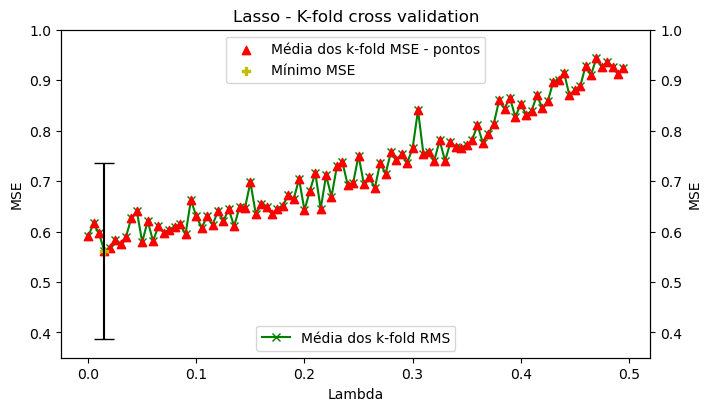

In [38]:
#Lasso Gráfico com resumo dos resultados
fig, axs = plt.subplots(1, 1, figsize=(7, 4), layout='constrained')

axs.plot(freg_list, np.mean(RMSl*(-1), axis = 1), color="g", marker = 'x', label = "Média dos k-fold RMS")
#plt.errorbar(freg_list, np.mean(RMS*(-1), axis = 1), yerr = np.std(RMS, axis = 1), ecolor='r',ls='',capsize = 7)
axs.set_ylim(0.35, 1.)
axs.set_xlabel("Lambda")  
axs.set_ylabel("MSE")  

#inclui segundo eixo y
axs1 = axs.twinx()

axs1.scatter(freg_list, np.mean(RMSl*(-1), axis = 1), color="r", marker = '^', label = "Média dos k-fold MSE - pontos")
axs1.scatter(lambda_minl [0,1], lambda_minl [0,2], color="y", marker = 'P', label = "Mínimo MSE")
plt.errorbar(lambda_minl [0,1], lambda_minl [0,2], yerr = lambda_minl [0,3]/2, ecolor='black',ls='',capsize = 7)
axs1.set_ylim(0.35, 1.)
axs1.set_ylabel("MSE")               

axs.legend(loc = 'lower center')
axs1.legend(loc = 'upper center')
axs.set_title("Lasso - K-fold cross validation")
plt.show()

## Ridge (Lambda selecionado)

In [39]:
ridge = Ridge(alpha=lambda_ridge, solver="auto")
ridge.fit(X_train, y_train)
ridge.intercept_, ridge.coef_

(2.4652375921213907,
 array([ 0.66795437,  0.26171698, -0.13837883,  0.20821166,  0.3014456 ,
        -0.27585641, -0.01781654,  0.25911689]))

In [40]:
# Visualizar R^2 - Ridge
print('Erro treino:', ridge.score(X_train, y_train))
print('Erro teste:', ridge.score(X_test, y_test))

Erro treino: 0.6943305226640326
Erro teste: 0.5064363412608336


In [41]:
#MSE

#predicoes
predt = ridge.predict(X_train)     #predicao dados de treinamento
pred = ridge.predict(X_test)     #predicao dados de teste


print('MSE treino:', mean_squared_error(y_train, predt))
print('MSE teste:', mean_squared_error(y_test, pred))

MSE treino: 0.4392581936694039
MSE teste: 0.5180657802293058


## Lasso (Lambda selecionado)

In [42]:
lasso = Lasso(alpha=lambda_lasso, max_iter=1000)
lasso.fit(X_train, y_train)
lasso.intercept_, lasso.coef_

(2.46766631157368,
 array([0.47289689, 0.08915936, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]))

In [43]:
# Visualizar R^2 - Lasso
print('Erro treino:', lasso.score(X_train, y_train))
print('Erro teste:', lasso.score(X_test, y_test))

Erro treino: 0.4889729635624892
Erro teste: 0.44427170257213655


In [44]:
#MSE

#predicoes
predt = lasso.predict(X_train)     #predicao dados de treinamento
pred = lasso.predict(X_test)     #predicao dados de teste


print('MSE treino:', mean_squared_error(y_train, predt))
print('MSE teste:', mean_squared_error(y_test, pred))

MSE treino: 0.7343645001723449
MSE teste: 0.5833164758076694
